# 1. SETTINGS

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

import os
import time
import multiprocessing

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import gc
gc.enable()

# 2. DATA PREPARATION

In [2]:
### IMPORT READY DATA
full_train = pd.read_csv('../input/full_train_v10.csv')
full_train.shape

(7848, 471)

In [3]:
### IMPORT READY DATA
meta_train = pd.read_csv('../input/training_set_metadata.csv')
meta_train = meta_train.sort_values('object_id')
meta_train.shape

(7848, 12)

In [4]:
### PREPARATIONS

# target encoding
if 'target' in meta_train:
    y = meta_train['target']
    del meta_train['target']
classes = sorted(y.unique())

# some features
if 'object_id' in meta_train:
    oof_df = meta_train[['object_id']]
    hostgal_photoz = meta_train['hostgal_photoz']

In [5]:
### IMPORT OOF PREDS
names = os.listdir('../preds_stacking')

for name in names:

    tmp = pd.read_csv('../preds_stacking/' + str(name))

    if 'object_id' in tmp:
        tmp = tmp.sort_values('object_id')
        del tmp['object_id']
    
    tmp.columns = [str(name) + '_' + str(l.replace('class_', '')) for l in list(tmp.columns)]    
    
    if name == names[0]:     
        full_train = tmp
        
    else:
        full_train = pd.concat([full_train, tmp], axis = 1)
            
print('- Number of stacking models:', len(names))
print('- Data shape:', full_train.shape)

- Number of stacking models: 2
- Data shape: (7848, 28)


In [6]:
### PARTITIONING

# partition the data
full_train_gal = full_train[hostgal_photoz == 0]
full_train_ext = full_train[hostgal_photoz != 0]
y_gal = y[hostgal_photoz == 0]
y_ext = y[hostgal_photoz != 0]

# save classes
classes_gal = np.sort(y_gal.unique())
classes_ext = np.sort(y_ext.unique())

# clear memory
del full_train

In [7]:
# remove constant columns
full_train_gal = full_train_gal.loc[:, full_train_gal.apply(pd.Series.nunique) != 1]
full_train_ext = full_train_ext.loc[:, full_train_ext.apply(pd.Series.nunique) != 1]

# 3. CROSS-VALIDATION

## GALACTIC OBJECTS

In [8]:
# exclude features
excluded_feats_gal = [f for f in full_train_gal.columns if f.endswith('_99')] + \
                     [f for f in full_train_gal.columns if f.endswith('_15')] + \
                     [f for f in full_train_gal.columns if f.endswith('_42')] + \
                     [f for f in full_train_gal.columns if f.endswith('_52')] + \
                     [f for f in full_train_gal.columns if f.endswith('_62')] + \
                     [f for f in full_train_gal.columns if f.endswith('_64')] + \
                     [f for f in full_train_gal.columns if f.endswith('_67')] + \
                     [f for f in full_train_gal.columns if f.endswith('_88')] + \
                     [f for f in full_train_gal.columns if f.endswith('_90')] + \
                     [f for f in full_train_gal.columns if f.endswith('_95')]
features_gal = [f for f in full_train_gal.columns if f not in excluded_feats_gal]
print(full_train_gal[features_gal].shape)

(2325, 10)


In [9]:
### LOSS FUNCTION
def multi_weighted_logloss(y_true, y_preds):
    
    classes = [6, 16, 53, 65, 92]
    class_weight = dict(((c, 1) for c in classes))
    
    # reshape
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order = 'F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a = y_p, a_min = 1e-15, a_max = 1-1e-15)
    
    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis = 0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis = 0).values.astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return 'wloss', loss, False


# recompute weights
w_gal = y_gal.value_counts()
weights_gal = {i : np.sum(w_gal) / w_gal[i] for i in w_gal.index}

In [10]:
### PARAMETERS

# LGB parameters
lgb_params = {
    'boosting_type':   'gbdt',
    'objective':       'multiclass',
    'num_class':        len(classes_gal),
    'metric':          'None',
    'subsample':        0.9,
    'feature_fraction': 0.7,
    'lambda_l1':        0.03,
    'lambda_l2':        0.03,
    'min_split_gain':   0.01,
    'min_child_weight': 5,
    'silent':           True,
    'verbosity':        -1,
    'learning_rate':    0.03,
    'max_depth':        3,
    'n_estimators':     5000,
    'nthread' :         16
}

# validation
folds = StratifiedKFold(n_splits     = 20, 
                        shuffle      = True, 
                        random_state = 108)

In [11]:
### CROSS-VALIDATION LOOP

# create objects
clfs_gal = []
importances_gal = pd.DataFrame()
oof_preds_gal = np.zeros((len(full_train_gal), len(classes_gal)))

# modeling loop
start  = time.time()
for fold_, (trn_, val_) in enumerate(folds.split(y_gal, y_gal)):
    
    # data partitioning
    trn_x, trn_y = full_train_gal[features_gal].iloc[trn_], y_gal.iloc[trn_]
    val_x, val_y = full_train_gal[features_gal].iloc[val_], y_gal.iloc[val_]
    
    # train the model
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf.fit(
        trn_x, trn_y,
        eval_set              = [(trn_x, trn_y), (val_x, val_y)],
        eval_metric           = multi_weighted_logloss,
        verbose               = 100,
        early_stopping_rounds = 50,
        sample_weight         = trn_y.map(weights_gal)
    )
    clfs_gal.append(clf)

    # predictions
    oof_preds_gal[val_, :] =  clf.predict_proba(val_x, num_iteration = clf.best_iteration_)
    
    # feedback
    print('-------------------------------------')
    print('Fold ' + str(fold_ + 1) + ': LOG-LOSS = ' + str(round(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration = clf.best_iteration_))[1], 5)))  
    print('-------------------------------------')
    print('')

    # variable importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = features_gal
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances_gal = pd.concat([importances_gal, imp_df], axis = 0, sort = False)
    
    # clean up
    gc.collect()
    
# print performance
print('')
print('MULTI-WEIGHTED LOG-LOSS : %.5f ' % multi_weighted_logloss(y_true = y_gal, y_preds = oof_preds_gal)[1])
print('Done in %5.1f minutes' % ((time.time() - start) / 60))

# 0.02530
# 0.02270

Training until validation scores don't improve for 50 rounds.
[100]	training's wloss: 0.0778748	valid_1's wloss: 0.0779211
[200]	training's wloss: 0.00863155	valid_1's wloss: 0.0131511
[300]	training's wloss: 0.0027238	valid_1's wloss: 0.0093633
[400]	training's wloss: 0.00208135	valid_1's wloss: 0.00886539
Early stopping, best iteration is:
[419]	training's wloss: 0.00200569	valid_1's wloss: 0.00875063
-------------------------------------
Fold 1: LOG-LOSS = 0.00875
-------------------------------------

Training until validation scores don't improve for 50 rounds.
[100]	training's wloss: 0.0777876	valid_1's wloss: 0.0758865
[200]	training's wloss: 0.00836442	valid_1's wloss: 0.010482
[300]	training's wloss: 0.00256107	valid_1's wloss: 0.00646293
[400]	training's wloss: 0.00193868	valid_1's wloss: 0.00590446
Early stopping, best iteration is:
[427]	training's wloss: 0.00184653	valid_1's wloss: 0.00587215
-------------------------------------
Fold 2: LOG-LOSS = 0.00587
----------------

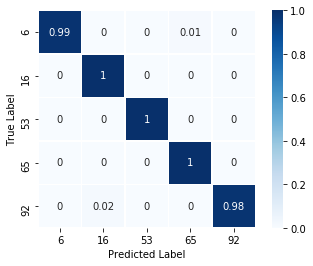

In [12]:
##### CONFUSION MATRIX

# preparations
tmp = np.argmax(oof_preds_gal, axis = 1)
y_pred = []
for i in tmp:
    y_pred.append(classes_gal[i])
y_pred = pd.Series(y_pred)

# construct confusion matrx
cm = confusion_matrix(y_gal, y_pred, labels = classes_gal)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (6,4))
sns.heatmap(cm, xticklabels = classes_gal, yticklabels = classes_gal, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

## EXTRAGALACTIC OBJECTS

In [13]:
# exclude features
excluded_feats_ext = [f for f in full_train_ext.columns if f.endswith('_99')] + \
                     [f for f in full_train_ext.columns if f.endswith('_6')] + \
                     [f for f in full_train_ext.columns if f.endswith('_16')] + \
                     [f for f in full_train_ext.columns if f.endswith('_53')] + \
                     [f for f in full_train_ext.columns if f.endswith('_65')] + \
                     [f for f in full_train_ext.columns if f.endswith('_92')]
features_ext = [f for f in full_train_ext.columns if f not in excluded_feats_ext]
print(full_train_ext[features_ext].shape)

(5523, 18)


In [14]:
### LOSS FUNCTION
def multi_weighted_logloss(y_true, y_preds):
    
    classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
    class_weight = dict(((c, 1) for c in classes))
    class_weight = {15: 1, 42: 1, 52: 1, 62: 1, 64: 1, 67: 1, 88: 1, 90: 1, 95: 1}
    
    # reshape
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order = 'F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a = y_p, a_min = 1e-15, a_max = 1-1e-15)
    
    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis = 0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis = 0).values.astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return 'wloss', loss, False


# recompute weights
w_ext = y_ext.value_counts()
weights_ext = {i : np.sum(w_ext) / w_ext[i] for i in w_ext.index}

In [15]:
### PARAMETERS

# LGB parameters
lgb_params = {
    'boosting_type':   'gbdt',
    'objective':       'multiclass',
    'num_class':        len(classes_ext),
    'metric':          'None',
    'subsample':        0.9,
    'feature_fraction': 0.7,
    'lambda_l1':        0.03,
    'lambda_l2':        0.03,
    'min_split_gain':   0.01,
    'min_child_weight': 5,
    'silent':           True,
    'verbosity':        -1,
    'learning_rate':    0.03,
    'max_depth':        3,
    'n_estimators':     5000,
    'nthread' :         16
}

# validation
folds = StratifiedKFold(n_splits     = 20, 
                        shuffle      = True, 
                        random_state = 108)

In [16]:
### CROSS-VALIDATION LOOP

# create objects
clfs_ext = []
importances_ext = pd.DataFrame()
oof_preds_ext = np.zeros((len(full_train_ext), len(classes_ext)))

# modeling loop
start  = time.time()
for fold_, (trn_, val_) in enumerate(folds.split(y_ext, y_ext)):
    
    # data partitioning
    trn_x, trn_y = full_train_ext[features_ext].iloc[trn_], y_ext.iloc[trn_]
    val_x, val_y = full_train_ext[features_ext].iloc[val_], y_ext.iloc[val_]
    
    # train the model
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf.fit(
        trn_x, trn_y,
        eval_set              = [(trn_x, trn_y), (val_x, val_y)],
        eval_metric           = multi_weighted_logloss,
        verbose               = 100,
        early_stopping_rounds = 50,
        sample_weight         = trn_y.map(weights_ext)        
    )
    clfs_ext.append(clf)

    # predictions
    oof_preds_ext[val_, :] = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)

    # feedback
    print('-------------------------------------')
    print('Fold ' + str(fold_ + 1) + ': LOG-LOSS = ' + str(round(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration = clf.best_iteration_))[1], 5)))  
    print('-------------------------------------')
    print('')

    # variable importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = features_ext
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances_ext = pd.concat([importances_ext, imp_df], axis = 0, sort = False)
    
    # clean up
    gc.collect()
    
# print performance
print('')
print('MULTI-WEIGHTED LOG-LOSS : %.5f ' % multi_weighted_logloss(y_true = y_ext, y_preds = oof_preds_ext)[1])
print('Done in %5.1f minutes' % ((time.time() - start) / 60))
 
# 0.71755
# 0.71878

Training until validation scores don't improve for 50 rounds.
[100]	training's wloss: 0.654957	valid_1's wloss: 0.752036
[200]	training's wloss: 0.530081	valid_1's wloss: 0.675629
Early stopping, best iteration is:
[241]	training's wloss: 0.50462	valid_1's wloss: 0.670301
-------------------------------------
Fold 1: LOG-LOSS = 0.6703
-------------------------------------

Training until validation scores don't improve for 50 rounds.
[100]	training's wloss: 0.649299	valid_1's wloss: 0.833877
[200]	training's wloss: 0.525154	valid_1's wloss: 0.794356
Early stopping, best iteration is:
[181]	training's wloss: 0.538342	valid_1's wloss: 0.790599
-------------------------------------
Fold 2: LOG-LOSS = 0.7906
-------------------------------------

Training until validation scores don't improve for 50 rounds.
[100]	training's wloss: 0.655388	valid_1's wloss: 0.709426
[200]	training's wloss: 0.5308	valid_1's wloss: 0.65092
[300]	training's wloss: 0.472793	valid_1's wloss: 0.655151
Early stopp

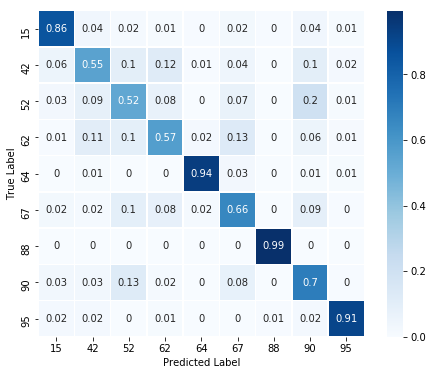

In [17]:
##### CONFUSION MATRIX

# preparations
tmp = np.argmax(oof_preds_ext, axis = 1)
y_pred = []
for i in tmp:
    y_pred.append(classes_ext[i])
y_pred = pd.Series(y_pred)

# construct confusion matrx
cm = confusion_matrix(y_ext, y_pred, labels = classes_ext)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(cm, xticklabels = classes_ext, yticklabels = classes_ext, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

## OVERALL PERFORMANCE

In [18]:
### LOSS FUNCTION
def multi_weighted_logloss(y_true, y_preds):
    
    # classes
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 1, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 1, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    
    # reshape
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order = 'F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    
    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis = 0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis = 0).values.astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return 'wloss', loss, False

In [19]:
# merge predictions
pd_gal = pd.DataFrame(oof_preds_gal, columns = classes_gal, index = y_gal.index)
pd_ext = pd.DataFrame(oof_preds_ext, columns = classes_ext, index = y_ext.index)

# transform predictions
oof_preds = pd.concat([pd_gal, pd_ext], axis = 1)
oof_preds.sort_index(axis = 1, inplace = True)
oof_preds.fillna(0, inplace = True)

# calibration
#for cl in oof_preds.columns:
#    oof_preds.loc[oof_preds[cl] < 0.05, cl] = oof_preds.loc[oof_preds[cl] < 0.05, cl]*1  # 0.85
#    oof_preds.loc[oof_preds[cl] > 0.95, cl] = oof_preds.loc[oof_preds[cl] > 0.95, cl]*1  # 1.55
    
# reshape
oof_preds_df = oof_preds.divide(oof_preds.sum(axis = 1), axis = 0)
oof_preds = oof_preds_df.values

# rounding
#oof_preds = np.round(oof_preds, decimals = 4)

In [20]:
##### EVALUATE PERFORMANCE

# print log-loss
cv_perf = multi_weighted_logloss(y_true = y, y_preds = oof_preds)[1]
print('MULTI-WEIGHTED LOG-LOSS : %.5f ' % cv_perf)

# 0.47045
# 0.47018
# 0.46916

MULTI-WEIGHTED LOG-LOSS : 0.45979 


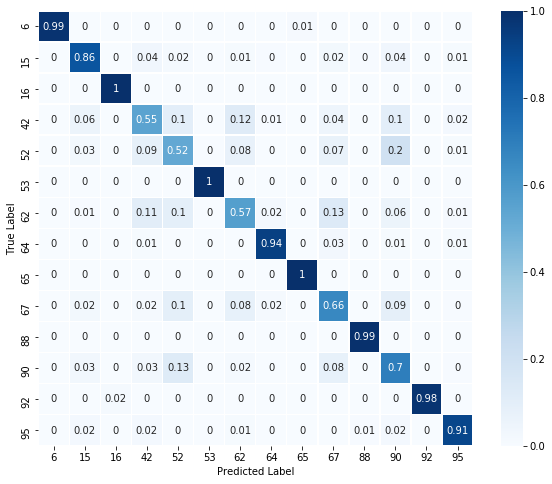

In [21]:
##### CONFUSION MATRIX

# preparations
tmp = np.argmax(oof_preds, axis = 1)
y_pred = []
for i in tmp:
    y_pred.append(classes[i])
y_pred = pd.Series(y_pred)

# construct confusion matrx
cm = confusion_matrix(y, y_pred, labels = classes)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(cm, xticklabels = classes, yticklabels = classes, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
fig.savefig('../confusion_matrix.pdf')

# 4. PREDICTIONS

## CONSTRUCTING TEST DATA

In [22]:
### IMPORT READY DATA
meta_test = pd.read_csv('../input/test_set_metadata.csv')
meta_test = meta_test.sort_values('object_id')
del meta_test['hostgal_specz']

In [23]:
### IMPORT TEST PREDS
for name in names:

    tmp = pd.read_csv('../submissions/' + str(name))
    tmp.columns = [str(name) + '_' + str(l.replace('class_', '')) for l in list(tmp.columns)]
    
    if name == names[0]:     
        full_test = tmp
        
    else:
        full_test = pd.concat([full_test, tmp], axis = 1)
        
print('Number of stacking models:', len(names))
print('Data shape:', full_test.shape)

Number of stacking models: 2
Data shape: (3492890, 32)


In [24]:
### PARTITIONING

# partition the data
full_test_gal = full_test[meta_test.hostgal_photoz == 0]
full_test_ext = full_test[meta_test.hostgal_photoz != 0]

# clear memory
del full_test

## PREDICTIONS

In [25]:
### PREDICT GALACTIC OBJECTS

# make predictions
start  = time.time()
preds_gal = None
for clf in clfs_gal:
    if preds_gal is None:
        preds_gal =  clf.predict_proba(full_test_gal[features_gal], num_iteration = clf.best_iteration_) / (folds.n_splits)
    else:
        preds_gal += clf.predict_proba(full_test_gal[features_gal], num_iteration = clf.best_iteration_) / (folds.n_splits)

# class 99 preds
preds_99 = np.ones(preds_gal.shape[0])
for i in range(preds_gal.shape[1]):
    preds_99 *= (1 - preds_gal[:, i])

# store predictions
preds_df_gal = pd.DataFrame(preds_gal, columns = ['class_' + str(s) for s in clfs_gal[0].classes_])
preds_df_gal['object_id'] = meta_test['object_id'][meta_test.hostgal_photoz == 0].values
preds_df_gal['class_99'] = preds_99
preds_df_gal['class_99'] = 0.18 * preds_99 / np.mean(preds_99)

# clean up
gc.collect()
print('Predictions shape: ', preds_df_gal.shape)
print('Done in %5.1f minutes' % ((time.time() - start) / 60))

Predictions shape:  (390510, 7)
Done in   0.9 minutes


In [26]:
### PREDICT EXTRAGALACTIC OBJECTS

# make predictions
start  = time.time()
preds_ext = None
for clf in clfs_ext:
    if preds_ext is None:
        preds_ext =  clf.predict_proba(full_test_ext[features_ext], num_iteration = clf.best_iteration_) / (folds.n_splits)
    else:
        preds_ext += clf.predict_proba(full_test_ext[features_ext], num_iteration = clf.best_iteration_) / (folds.n_splits)

# class 99 preds
preds_99 = np.ones(preds_ext.shape[0])
for i in range(preds_ext.shape[1]):
    preds_99 *= (1 - preds_ext[:, i])

# store predictions
preds_df_ext = pd.DataFrame(preds_ext, columns = ['class_' + str(s) for s in clfs_ext[0].classes_])
preds_df_ext['object_id'] = meta_test['object_id'][meta_test.hostgal_photoz != 0].values
preds_df_ext['class_99'] = preds_99
preds_df_ext['class_99'] = 0.18 * preds_99 / np.mean(preds_99)

# clean up
gc.collect()
print('Predictions shape: ', preds_df_ext.shape)
print('Done in %5.1f minutes' % ((time.time() - start) / 60))

Predictions shape:  (3102380, 11)
Done in   8.9 minutes


# 6. CALIBRATION

In [27]:
# merge predictions
sub = pd.concat([preds_df_gal, preds_df_ext], axis = 0)
sub = sub.sort_values('object_id', ascending = True)
sub.fillna(0, inplace = True)

In [28]:
# sort and reindex
sub = sub.sort_values('object_id', ascending = True)
sub = sub.sort_index(axis = 1)
sub = sub.reset_index(drop = True)

In [29]:
# null values for galactic / extragalactic
meta_test = pd.read_csv('../input/test_set_metadata.csv')
meta_test = meta_test.sort_values('object_id')

for cl in ['class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95']:
    sub.loc[meta_test.hostgal_photoz == 0, cl] = 0

for cl in ['class_6', 'class_16', 'class_53', 'class_65', 'class_92']:
    sub.loc[meta_test.hostgal_photoz != 0, cl] = 0

In [30]:
# normalize sum to unity
sums = sub[['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']].sum(axis = 1)
for cl in ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']:
    sub[cl] = sub[cl] / sums

In [31]:
### class 99 computation: Scripus version
def GenUnknown(data):
    return ((((((data["mymedian"]) + (((data["mymean"]) / 2.0)))/2.0)) + (((((1.0) - (((data["mymax"]) * (((data["mymax"]) * (data["mymax"]))))))) / 2.0)))/2.0)

feats = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']

y = pd.DataFrame()
y['mymean']   = sub[feats].mean(axis=1)
y['mymedian'] = sub[feats].median(axis=1)
y['mymax']    = sub[feats].max(axis=1)

sub['class_99'] = GenUnknown(y)

# 7. SUBMISSION

In [34]:
# file name
model = 'stack_2level_20f'
perf  = str(round(cv_perf, 5))[2:7]
name  = model + '_' + perf

In [35]:
# export submission
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape

(3492890, 16)